# Structure

* [Dataset](#dataset)
* [SVM Model](#svm_model)
* [Clustering](#clustering)


In [628]:
import numpy as np
import pandas as pd

from sklearn import datasets

from sklearn.preprocessing import minmax_scale, StandardScaler

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, accuracy_score

import matplotlib.pyplot as plt
from typing import List

## <a id='dataset'>Dataset</a>

In [629]:
# Load & construct dataset
iris = datasets.load_iris()
iris_array = np.concatenate([iris['data'],  iris['target'].reshape(-1, 1)], axis = 1)

features, classes = iris['feature_names'], iris['target_names'].tolist()

dataset = pd.DataFrame.from_records(iris_array, columns = features + ['class'])

In [630]:
# Standartize column names
dataset.columns = [column_name.replace(' (cm)', '') for column_name in dataset.columns]
dataset.columns = [column_name.replace(' ', '_') for column_name in dataset.columns]

In [631]:
# Scale independent features via min-max method
columns_to_scale = dataset.columns.difference(['class'])
X = minmax_scale(dataset[columns_to_scale])
y = dataset['class']

In [632]:
# Shuffle & split dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## <a id='svm_model'>SVM Model</a>

In [633]:
# Hyperparameters initialization
random_state = 9
hparams_grid = {
    'C': [0.1, 0.5, 1.0],
    'kernel': ['linear', 'poly', 'sigmoid']
    }

In [634]:
# Model initialization
model = SVC(random_state=random_state)

In [635]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END C=0.1, kernel=linear;, score=(train=0.690, test=0.667) total time=   0.0s
[CV 2/5] END C=0.1, kernel=linear;, score=(train=0.821, test=0.810) total time=   0.0s
[CV 3/5] END C=0.1, kernel=linear;, score=(train=0.821, test=0.857) total time=   0.0s
[CV 4/5] END C=0.1, kernel=linear;, score=(train=0.762, test=0.714) total time=   0.0s
[CV 5/5] END C=0.1, kernel=linear;, score=(train=0.881, test=0.857) total time=   0.0s
[CV 1/5] END C=0.1, kernel=poly;, score=(train=0.976, test=1.000) total time=   0.0s
[CV 2/5] END C=0.1, kernel=poly;, score=(train=0.976, test=0.905) total time=   0.0s
[CV 3/5] END C=0.1, kernel=poly;, score=(train=0.976, test=0.905) total time=   0.0s
[CV 4/5] END C=0.1, kernel=poly;, score=(train=0.964, test=1.000) total time=   0.0s
[CV 5/5] END C=0.1, kernel=poly;, score=(train=0.964, test=1.000) total time=   0.0s
[CV 1/5] END C=0.1, kernel=sigmoid;, score=(train=0.357, test=0.333) total time=

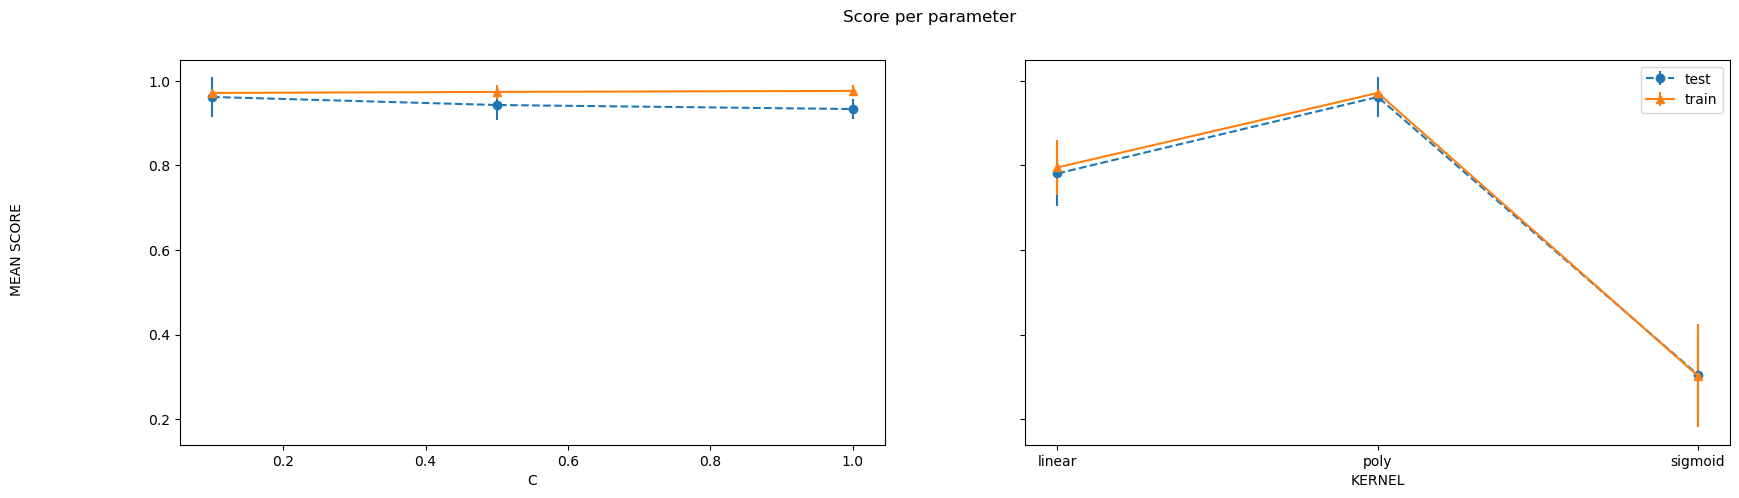

Best hyperparameters: {'C': 0.1, 'kernel': 'poly'}



In [636]:
# Hyperparameters tuning with Crid Search Cross-Validation
gs_ds = GridSearchCV(model, hparams_grid, cv = 5, scoring = 'accuracy', verbose = 3, return_train_score = True)
gs_ds.fit(X_train, y_train)
plot_search_results(gs_ds)
print(f"Best hyperparameters: {gs_ds.best_params_}\n")

In [637]:
# Assess model
best_model = gs_ds.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Accuracy on train data: {train_accuracy}")
print(f"Accuracy on test data: {test_accuracy}")

Accuracy on train data: 0.9619047619047619
Accuracy on test data: 1.0


## 😱
#### I can't believe the results

## <a id='clustering'>Clustering</a>

In [638]:
# Func finds out best parameters (in these cases eps or clusters) based on 3 metrics

def best_param(metrics: dict, params: list, param_type = "cluster") -> int:
    best_params = []

    for metric_name, metric in metrics.items():
        sorted_items = sorted(metric.items(), key=lambda item: item[1], reverse=True)

        if metric_name != "Davies-Bouldin Score":
            best_ind, _ = sorted_items[0]
            if best_ind == 2 and param_type != 'eps':
                best_ind, _ = sorted_items[1]
        elif best_ind != 2 and param_type != 'eps':
            best_ind, _ = sorted_items[-1]
            if best_ind == 2:
                best_ind, _ = sorted_items[-2]
        best_params.append(params[list(metric.keys()).index(best_ind)])
    
    return max(set(best_params), key = best_params.count)
    
    

In [639]:
def plot_metrics(metrics: dict, hyperparameter: str, additional_value: str = ""):
    metrics_num = len(metrics)
    fig, axes = plt.subplots(metrics_num, 1, sharex=False, figsize=(8, 10))
    fig.suptitle(f"Clustering Evaluation Metrics over Different {hyperparameter} Values ({additional_value})")

    for metric_name, metric in metrics.items():
        ax = axes[list(metrics.keys()).index(metric_name)]
        ax.plot(metric.keys(), metric.values(), marker='o')
        ax.set(xlabel=hyperparameter, ylabel=metric_name)
        ax.set_title(metric_name)

    plt.subplots_adjust(hspace=0.6)
    plt.show()

#### kMeans

In [640]:
# kMeans
random_state = 9
kMneans_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

In [641]:
def plot_kMeans(data: np.ndarray, clusters_num: int):
    kmeans = KMeans(n_clusters= clusters_num)
    label = kmeans.fit_predict(data)
    u_labels = np.unique(label)
 
    for i in u_labels:
        plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
    
    plt.title(f"Auto-Estimated number of clusters: {clusters_num}")
    plt.legend()
    plt.show()

In [642]:
def test_kMeans(data, cluster_num: List[int]):
    inertia_scores = {}
    silhouette_scores = {}
    calinski_scores = {}
    davies_scores = {}
    for clusters in cluster_num:
        model = KMeans(n_clusters=clusters, random_state = random_state)
        labels = model.fit_predict(data)
        

        inertia_scores[clusters] = model.inertia_
        silhouette_scores[clusters] = silhouette_score(data, labels)
        calinski_scores[clusters] = calinski_harabasz_score(data, labels)
        davies_scores[clusters] = davies_bouldin_score(data, labels)
        
    plot_metrics(
        {
            "Inertia": inertia_scores,
            "Silhouette Score": silhouette_scores,
            "Calinski-Harabasz Score": calinski_scores,
            "Davies-Bouldin Score": davies_scores,
        },
        "clusters"
    )

    best_clusters = best_param(
        metrics={
            "Silhouette Score": silhouette_scores,
            "Calinski-Harabasz Score": calinski_scores,
            "Davies-Bouldin Score": davies_scores,
        },
        params=cluster_num,
    )
    
    plot_kMeans(data=data, clusters_num=best_clusters)
    

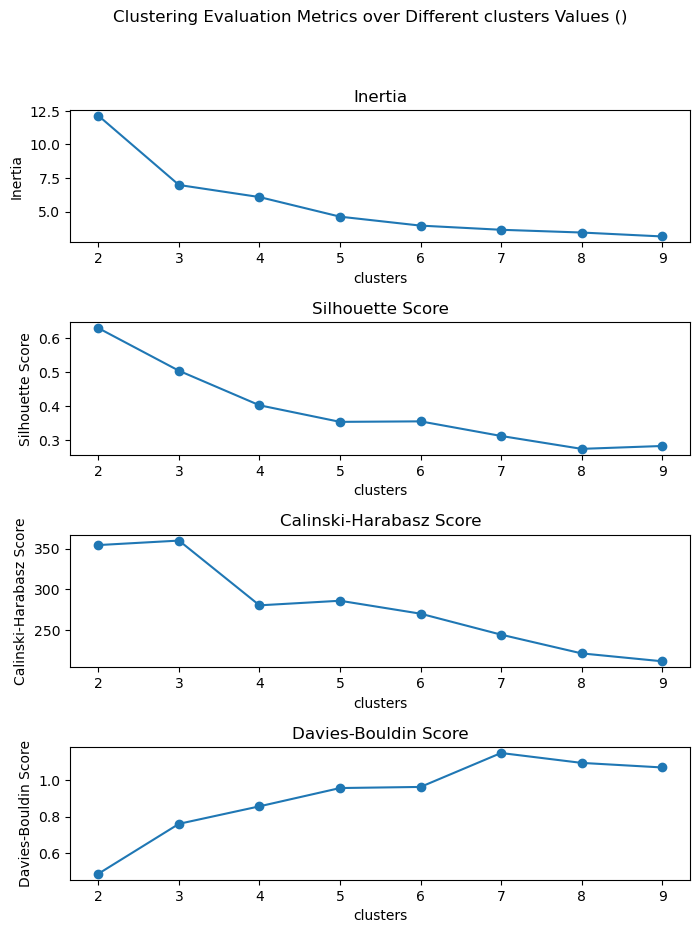

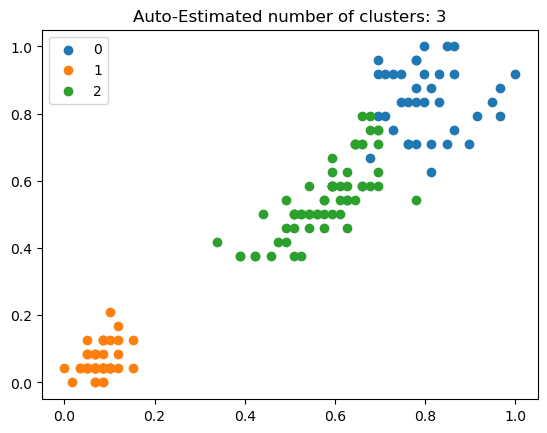

In [643]:
test_kMeans(X, kMneans_n_clusters)

#### Based on metrics it obviously was decided that the best number of clusters is `2`, but I've chosen maximum number of clusters proposed by metrics.
#### But using elbow method we can observe that the best number of clusters is `3` (and probably `5`).

#### DBSCAN

In [644]:
# DBSCAN
metric = 'euclidean'
algorithm = 'brute'
eps = [0.1, 0.2, 0.3, 0.4, 0.6, 0.9, 1.1, 1.5, 1.9]

In [645]:
def plot_dbscan(best_eps: float, data: np.ndarray, min_samples=5):
    db = DBSCAN(eps=best_eps, min_samples=min_samples).fit(data)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
        # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = data[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = data[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    plt.title(f"Auto-Estimated number of clusters: {n_clusters_}")
    plt.show()

In [646]:
def test_dbscan(data: np.ndarray, eps_list: List[int]):
    silhouette_scores = {}
    calinski_scores = {}
    davies_scores = {}
    clusters = []
    for eps in eps_list:
        labels = DBSCAN(eps=eps).fit_predict(data)
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        clusters.append(n_clusters_)
        
        if n_clusters_ > 1:
            sil_score = silhouette_score(data, labels) 
            calinski_score = calinski_harabasz_score(data, labels)
            davies_score = davies_bouldin_score(data, labels)
        else: 
            sil_score = 0
            calinski_score = 0
            davies_score = 1000

        silhouette_scores[eps] = sil_score
        calinski_scores[eps] = calinski_score
        davies_scores[eps] = davies_score
    
    plot_metrics(
        metrics={
            "Silhouette Score": silhouette_scores,
            "Calinski-Harabasz Score": calinski_scores,
            "Davies-Bouldin Score": davies_scores,
        },
        hyperparameter="eps",
    )
    
    best_eps = best_param(
        metrics={
            "Silhouette Score": silhouette_scores,
            "Calinski-Harabasz Score": calinski_scores,
            "Davies-Bouldin Score": davies_scores,
        },
        params=eps_list,
        param_type='eps'
    )

    plot_dbscan(best_eps=best_eps, data=data)
    

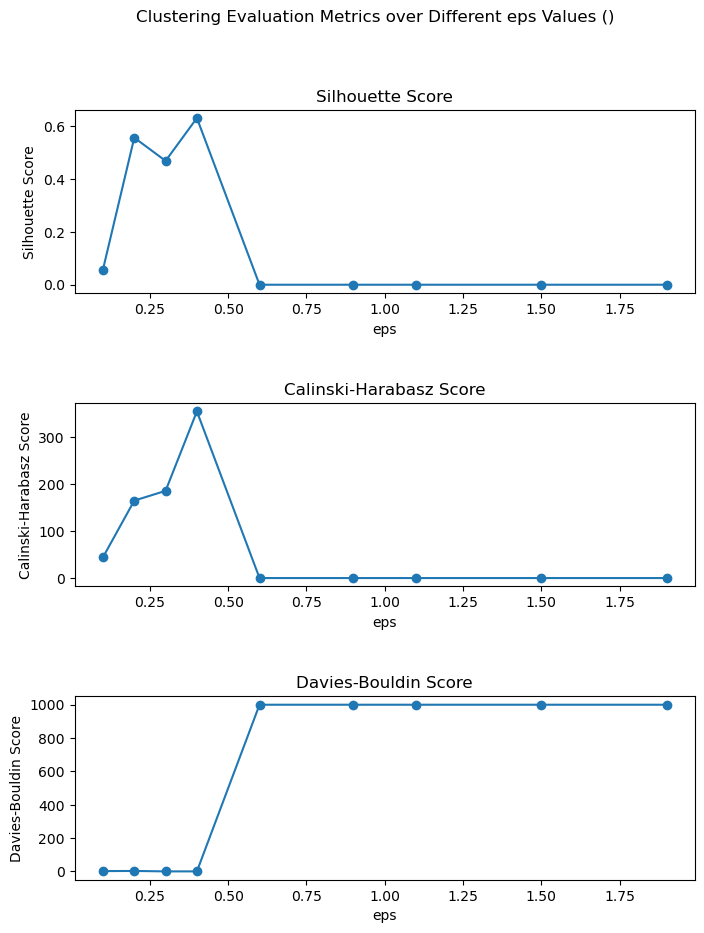

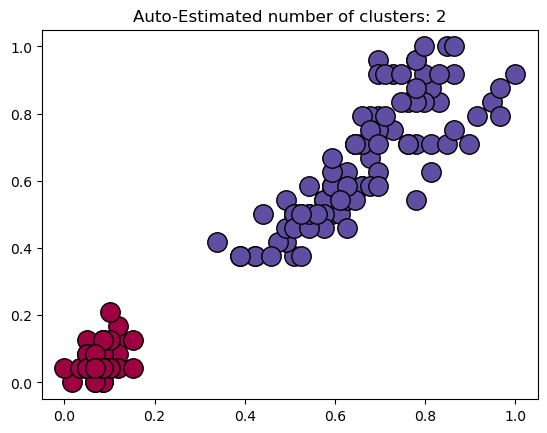

In [647]:
test_dbscan(X, eps)

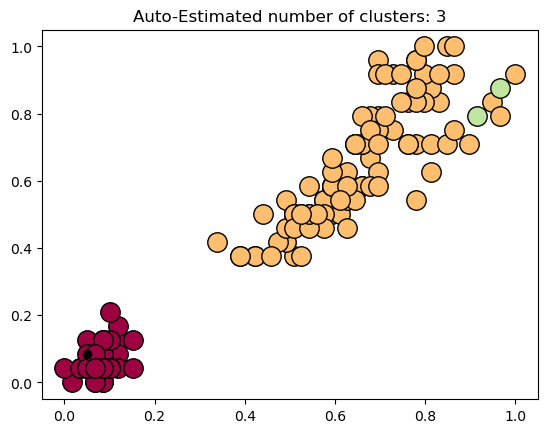

In [648]:
plot_dbscan(best_eps=0.2, data=X, min_samples=2)

#### Based on metric values it reveals that the best number of eps is `0.4` and number of clusters is `2`, model cannot find out more classes accurately - even with min_samples set to `2` and low eps equal `0.2` model defines weird clusters.

#### BIRCH

In [649]:
# BIRCH
branching_factor = 50
birch_n_clusters = [2, 3, 4, 6, 9]
birch_thresholds = [0.05 ,0.1, 0.3, 0.5, 0.9]

In [650]:
def plot_birch(n_clusters: int, data: np.ndarray, threshold: float):

    model = Birch(n_clusters=n_clusters, threshold=threshold)
    labels = model.fit_predict(data)

    plt.figure(figsize=(10, 6))
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        class_member_mask = (labels == k)
    
        xy = data[class_member_mask]
        plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14 if k != -1 else 6,
    )

    plt.title(f"BIRCH Clustering for {n_clusters} clusters")
    
    plt.show()

In [651]:
def test_birch(data: np.ndarray, cluster_nums: list, thresholds: list):
    silhouette_scores = {}
    calinski_scores = {}
    davies_scores = {}
    for threshold in thresholds:
        for clusters in cluster_nums:
            model = Birch(n_clusters=clusters, threshold=threshold)
            labels = model.fit_predict(data)

            if len(set(labels)) > 1:
                sil_score = silhouette_score(data, labels)
                calinski_score = calinski_harabasz_score(data, labels)
                davies_score = davies_bouldin_score(data, labels)
            else:
                sil_score = 0
                calinski_score = 0
                davies_score = 1000
            silhouette_scores[clusters] = sil_score
            calinski_scores[clusters] = calinski_score
            davies_scores[clusters] = davies_score
        plot_metrics(
        metrics={
            "Silhouette Score": silhouette_scores,
            "Calinski-Harabasz Score": calinski_scores,
            "Davies-Bouldin Score": davies_scores,
        },
        hyperparameter="clusters",
        additional_value=f"Threshold: {threshold}"
        )

        best_clusters = best_param(
            metrics={
            "Silhouette Score": silhouette_scores,
            "Calinski-Harabasz Score": calinski_scores,
            "Davies-Bouldin Score": davies_scores,
        },
            params=cluster_nums,
        )
    
        plot_birch(best_clusters, data, threshold)
        
    

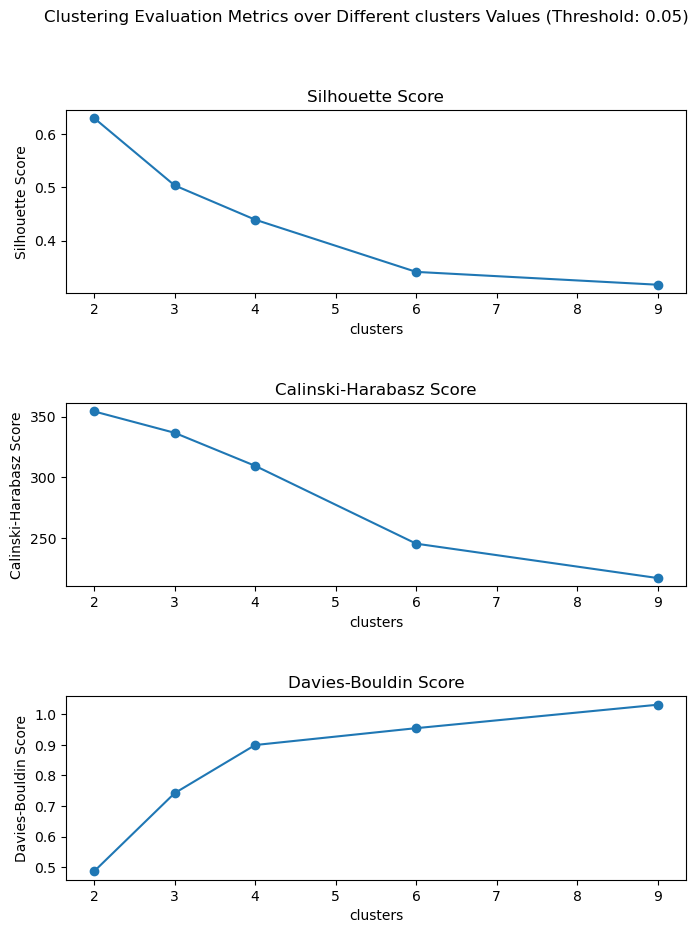

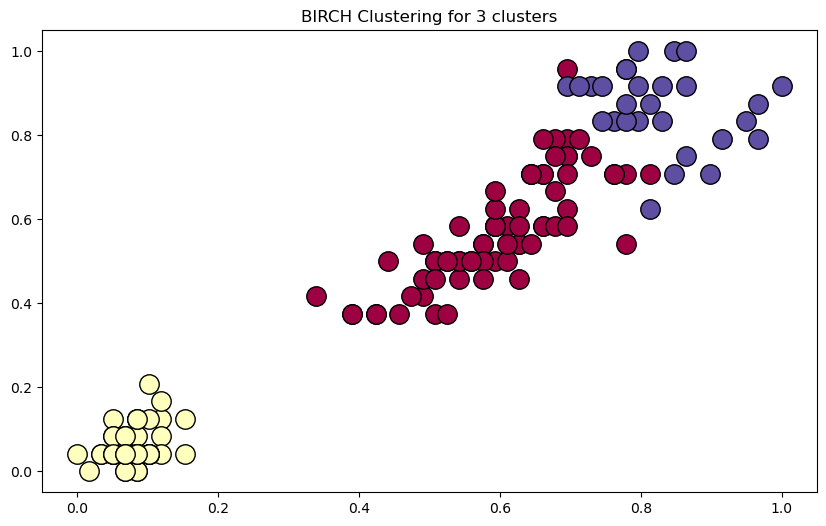

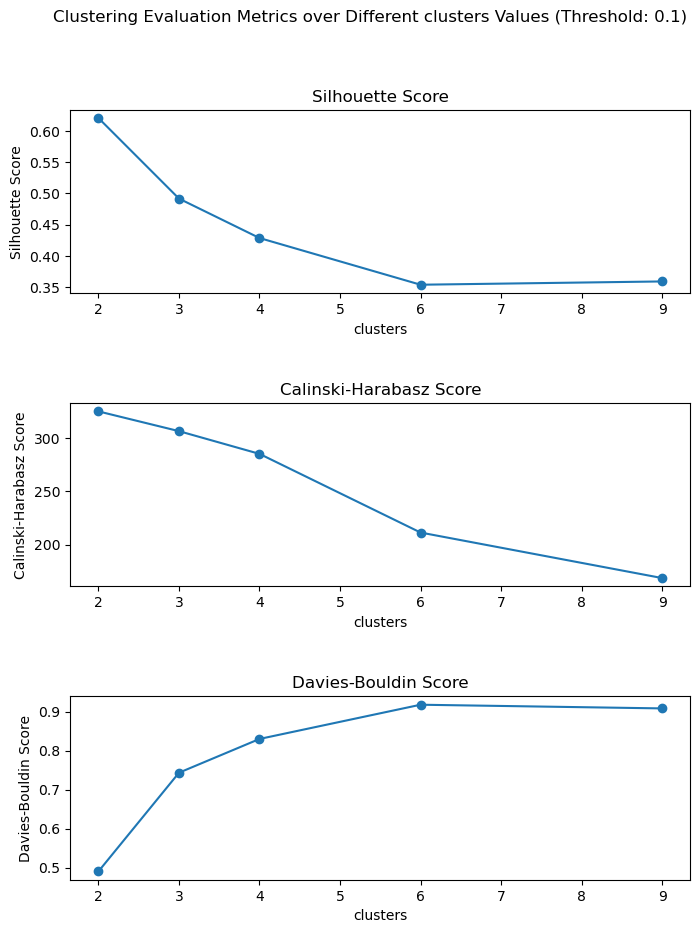

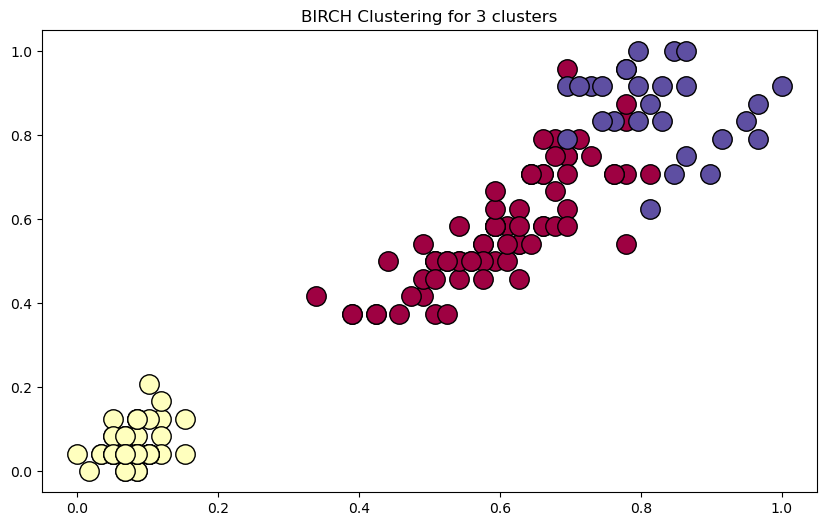

/opt/miniconda3/envs/hillel_ml/lib/python3.12/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (3) by BIRCH is less than (4). Decrease the threshold.
  warnings.warn(
/opt/miniconda3/envs/hillel_ml/lib/python3.12/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (3) by BIRCH is less than (6). Decrease the threshold.
  warnings.warn(
/opt/miniconda3/envs/hillel_ml/lib/python3.12/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (3) by BIRCH is less than (9). Decrease the threshold.
  warnings.warn(


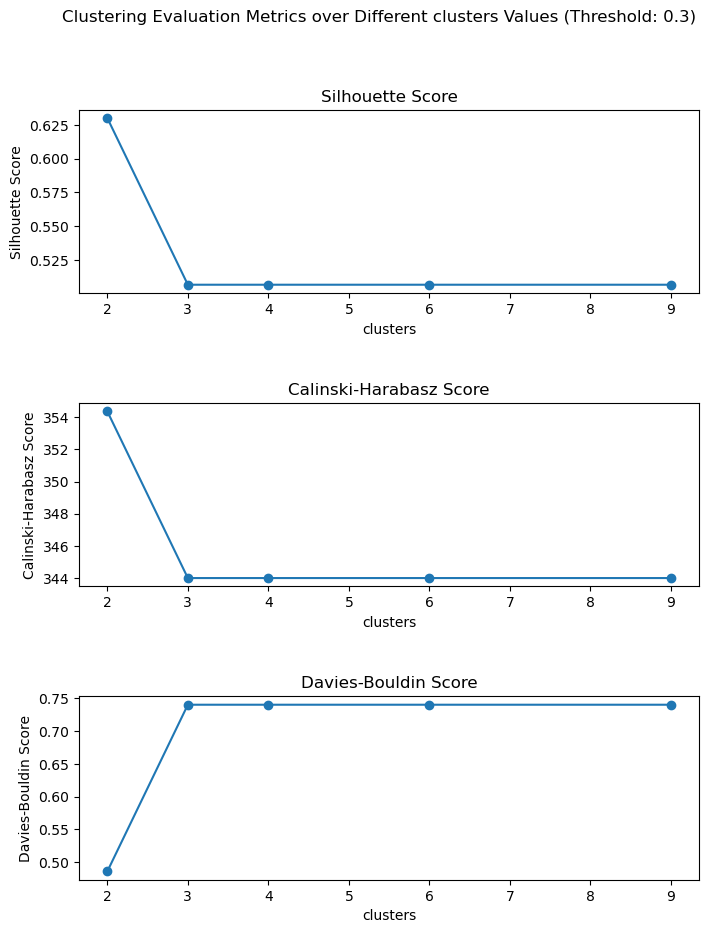

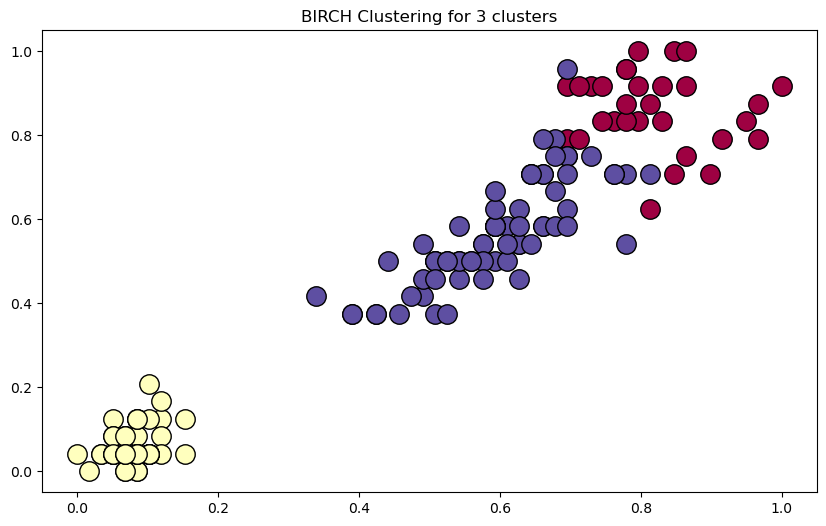

/opt/miniconda3/envs/hillel_ml/lib/python3.12/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (3). Decrease the threshold.
  warnings.warn(
/opt/miniconda3/envs/hillel_ml/lib/python3.12/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (4). Decrease the threshold.
  warnings.warn(
/opt/miniconda3/envs/hillel_ml/lib/python3.12/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (6). Decrease the threshold.
  warnings.warn(
/opt/miniconda3/envs/hillel_ml/lib/python3.12/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (9). Decrease the threshold.
  warnings.warn(


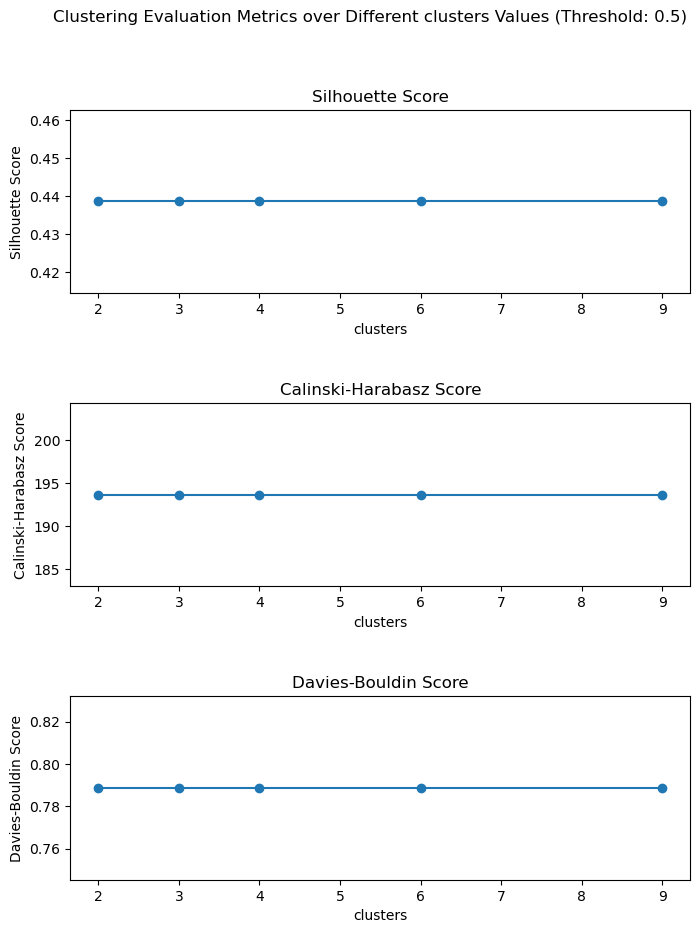

/opt/miniconda3/envs/hillel_ml/lib/python3.12/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (3). Decrease the threshold.
  warnings.warn(


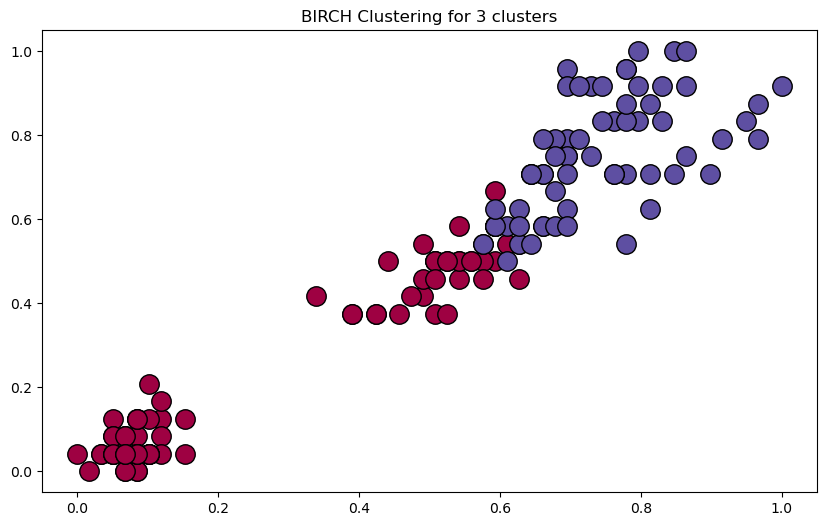

/opt/miniconda3/envs/hillel_ml/lib/python3.12/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (2). Decrease the threshold.
  warnings.warn(
/opt/miniconda3/envs/hillel_ml/lib/python3.12/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (3). Decrease the threshold.
  warnings.warn(
/opt/miniconda3/envs/hillel_ml/lib/python3.12/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (4). Decrease the threshold.
  warnings.warn(
/opt/miniconda3/envs/hillel_ml/lib/python3.12/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (6). Decrease the threshold.
  warnings.warn(
/opt/miniconda3/envs/hillel_ml/lib/python3.12/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is l

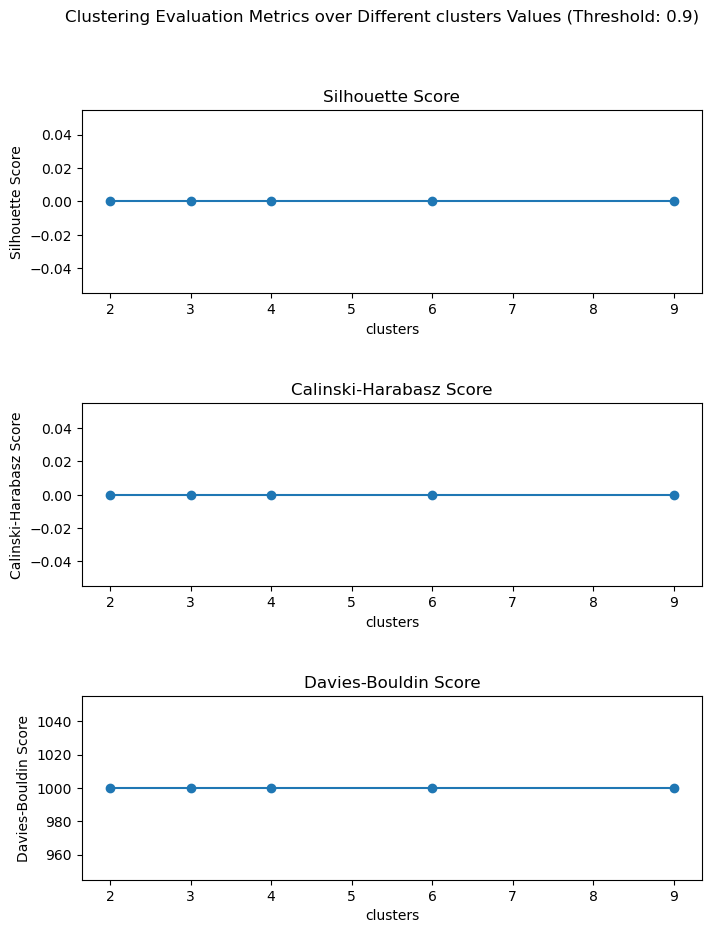

/opt/miniconda3/envs/hillel_ml/lib/python3.12/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (3). Decrease the threshold.
  warnings.warn(


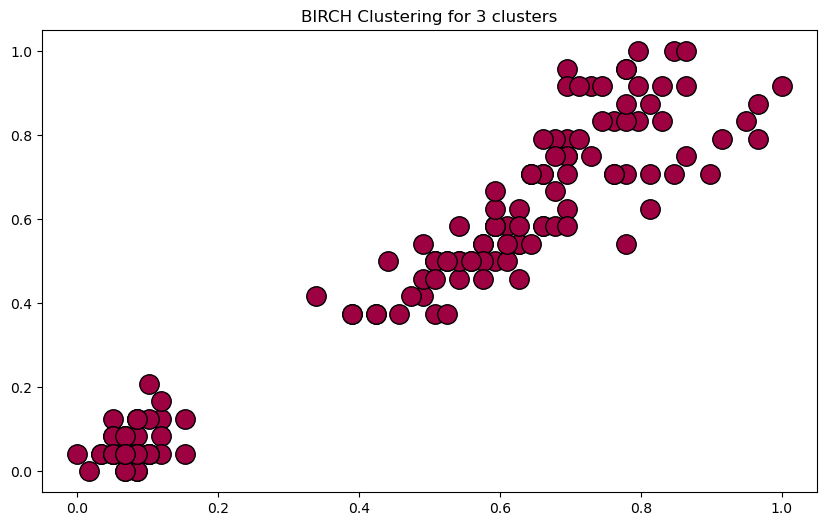

In [652]:
test_birch(X, birch_n_clusters, birch_thresholds)

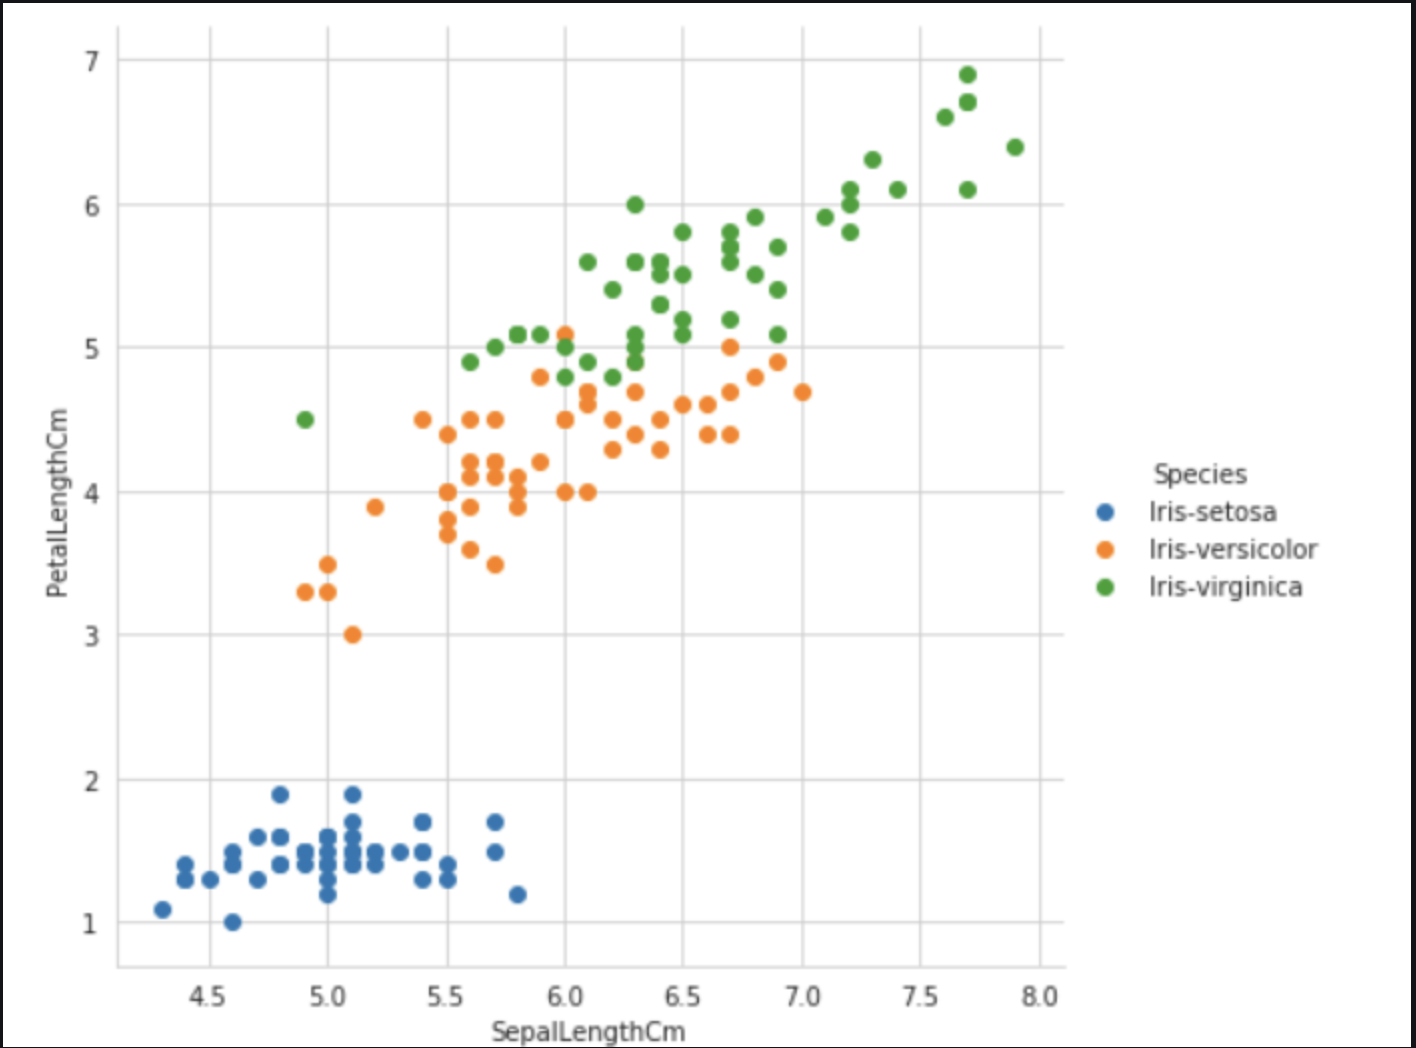

#### BIRCH performs quite well with threshold tuning that is algorithm is able to define correct clusters.

## Conclusion
* kMeans algorithm performs quite well with proper `clusters` tuning
* DBSCAN probably performs the worst due to data density -- bigger cluster in the right up corner on the picture above has almost uniform density, so it's tough task for DBSCAN
* BIRCH needs more tuning compared to kMeans but still performs quite well with proper `threshold` selection

Overall I would rate kMeans as the best for this task (do not mean clustering overall) since it requires less optimization efforts.
